In [ ]:
import numpy as np
import pandas as pd
import random

In [ ]:
data = pd.read_csv('investigatory_data.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Transform labels from -1/1 to a binary classification problem if necessary
y = np.where(y == -1, -1, 1)

# Normalize features for better convergence
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [ ]:
def split_data(X, y, k):
    split_index = int(k * len(X))
    return X[:split_index], y[:split_index], X[split_index:], y[split_index:]

# Example proportion of training data k=0.8
k = 0.8
X_train, y_train, X_test, y_test = split_data(X, y, k)

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 1680, Test set size: 420


In [ ]:
import time

In [ ]:
def standard_pla(X, y, max_iterations=1000):
    weights = np.zeros(X.shape[1])
    start_time = time.time()
    convergence_iterations = 0
    for it in range(max_iterations):
        converged = True
        for i in range(len(X)):
            if np.sign(np.dot(weights, X[i])) != y[i]:
                weights += y[i] * X[i]
                converged = False
        convergence_iterations += 1
        if converged:
            break
    end_time = time.time()
    time_taken = end_time - start_time
    return weights, convergence_iterations, time_taken

# Apply Standard PLA
weights_standard, iterations_standard, time_standard = standard_pla(X_train, y_train)
print(f"Standard PLA converged in {iterations_standard} iterations, Time taken: {time_standard:.4f} seconds")


Standard PLA converged in 1000 iterations, Time taken: 4.2726 seconds


In [ ]:
def randomised_pla(X, y, max_iterations=1000):
    weights = np.zeros(X.shape[1])
    start_time = time.time()
    convergence_iterations = 0
    for it in range(max_iterations):
        misclassified = [i for i in range(len(X)) if np.sign(np.dot(weights, X[i])) != y[i]]
        if not misclassified:
            break
        i = random.choice(misclassified)
        weights += y[i] * X[i]
        convergence_iterations += 1
    end_time = time.time()
    time_taken = end_time - start_time
    return weights, convergence_iterations, time_taken

# Apply Randomised PLA
weights_randomised, iterations_randomised, time_randomised = randomised_pla(X_train, y_train)
print(f"Randomised PLA converged in {iterations_randomised} iterations, Time taken: {time_randomised:.4f} seconds")


Randomised PLA converged in 1000 iterations, Time taken: 5.8934 seconds


In [ ]:
def pocket_pla(X, y, max_iterations=1000):
    weights = np.zeros(X.shape[1])
    start_time = time.time()
    best_weights = weights.copy()
    best_error = np.sum(np.sign(np.dot(X, weights)) != y)
    convergence_iterations = 0

    for _ in range(max_iterations):
        converged = True
        for i in range(len(X)):
            if np.sign(np.dot(weights, X[i])) != y[i]:
                weights += y[i] * X[i]
                current_error = np.sum(np.sign(np.dot(X, weights)) != y)
                if current_error < best_error:
                    best_error = current_error
                    best_weights = weights.copy()
                converged = False
        convergence_iterations += 1
        if converged:
            break
    end_time = time.time()
    time_taken = end_time - start_time
    return best_weights, convergence_iterations, time_taken

# Apply Pocket PLA
weights_pocket, iterations_pocket, time_pocket = pocket_pla(X_train, y_train)
print(f"Pocket PLA converged in {iterations_pocket} iterations, Time taken: {time_pocket:.4f} seconds")


Pocket PLA converged in 1000 iterations, Time taken: 13.6714 seconds


In [ ]:
def calculate_error(X, y, weights):
    predictions = np.sign(np.dot(X, weights))
    return np.mean(predictions != y)

# Calculate In-Sample and Out-of-Sample Error
E_in_standard = calculate_error(X_train, y_train, weights_standard)
E_in_randomised = calculate_error(X_train, y_train, weights_randomised)
E_in_pocket = calculate_error(X_train, y_train, weights_pocket)

E_out_standard = calculate_error(X_test, y_test, weights_standard)
E_out_randomised = calculate_error(X_test, y_test, weights_randomised)
E_out_pocket = calculate_error(X_test, y_test, weights_pocket)

# Print Errors
print(f"Standard PLA - E_in: {E_in_standard}, E_out: {E_out_standard}")
print(f"Randomised PLA - E_in: {E_in_randomised}, E_out: {E_out_randomised}")
print(f"Pocket PLA - E_in: {E_in_pocket}, E_out: {E_out_pocket}")


Standard PLA - E_in: 0.007738095238095238, E_out: 0.0880952380952381
Randomised PLA - E_in: 0.06190476190476191, E_out: 0.09761904761904762
Pocket PLA - E_in: 0.002976190476190476, E_out: 0.1


In [ ]:
def find_best_k_ratio(X, y, method, k_values, max_iterations=1000):
    E_in_values = []
    E_out_values = []
    ratio_values = []

    for k in k_values:
        X_train, y_train, X_test, y_test = split_data(X, y, k)

        if method == 'standard':
            weights, _, _ = standard_pla(X_train, y_train, max_iterations)
        elif method == 'randomized':
            weights, _, _ = randomised_pla(X_train, y_train, max_iterations)
        elif method == 'pocket':
            weights, _, _ = pocket_pla(X_train, y_train, max_iterations)
        else:
            raise ValueError("Invalid method")

        E_in = calculate_error(X_train, y_train, weights)
        E_out = calculate_error(X_test, y_test, weights)

        E_in_values.append(E_in)
        E_out_values.append(E_out)

        ratio = E_in / E_out if E_out != 0 else np.inf
        ratio_values.append(ratio)

    # Find the k that gives the ratio closest to 1
    optimal_k_idx = np.argmin(np.abs(np.array(ratio_values) - 1))
    optimal_k = k_values[optimal_k_idx]

    return optimal_k, ratio_values, E_in_values, E_out_values

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
def plot_decision_boundary_for_optimal_k(X, y, method, optimal_k, max_iterations=1000):

    # Split data according to the optimal_k value
    X_train, y_train, X_test, y_test = split_data(X, y, optimal_k)

    # Apply the chosen PLA method
    if method == 'standard':
        weights, _, _ = standard_pla(X_train, y_train, max_iterations)
    elif method == 'randomized':
        weights, _, _ = randomised_pla(X_train, y_train, max_iterations)
    elif method == 'pocket':
        weights, _, _ = pocket_pla(X_train, y_train, max_iterations)
    else:
        raise ValueError("Invalid method")

    # Apply PCA to reduce data to 2D for plotting
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Create the plot
    plt.figure(figsize=(10, 7))

    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='bwr', alpha=0.6, label="Train Data")

    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', marker='x', alpha=0.6, label="Test Data")

    slope = -weights[0] / weights[1] if weights[1] != 0 else 0
    intercept = 0

    x_vals = np.linspace(min(X_train_pca[:, 0]), max(X_train_pca[:, 0]), 100)
    y_vals = slope * x_vals + intercept

    plt.plot(x_vals, y_vals, 'k--', label=f"{method.capitalize()} PLA Decision Boundary")

    plt.title(f"{method.capitalize()} PLA Decision Boundary (Optimal k = {optimal_k:.2f})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

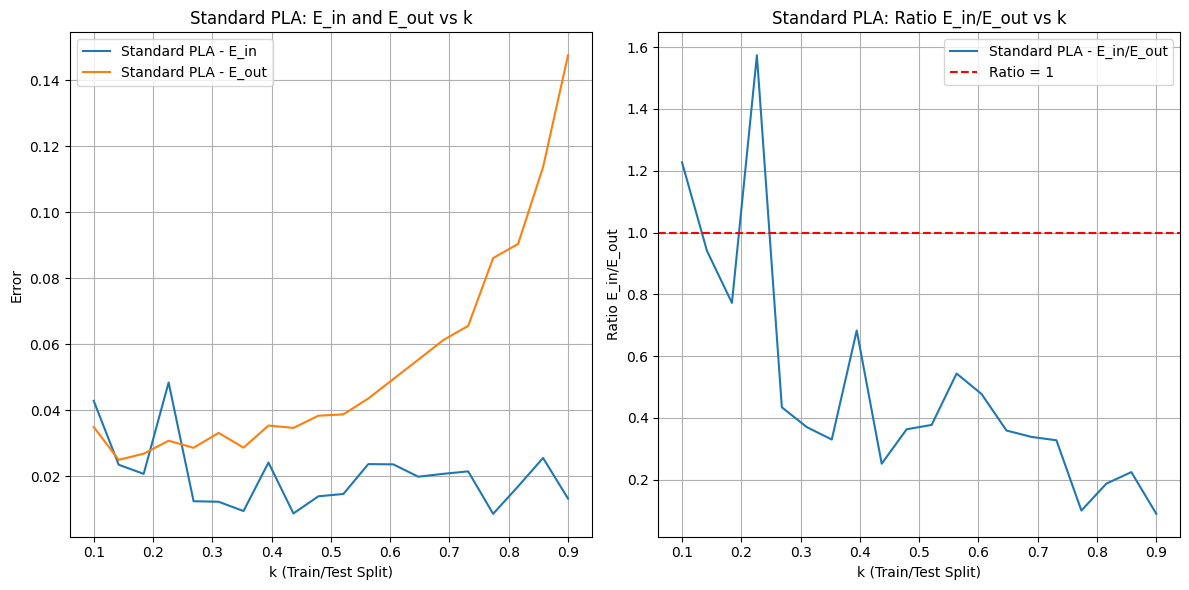

Optimal k for Standard PLA: 0.14210526315789473


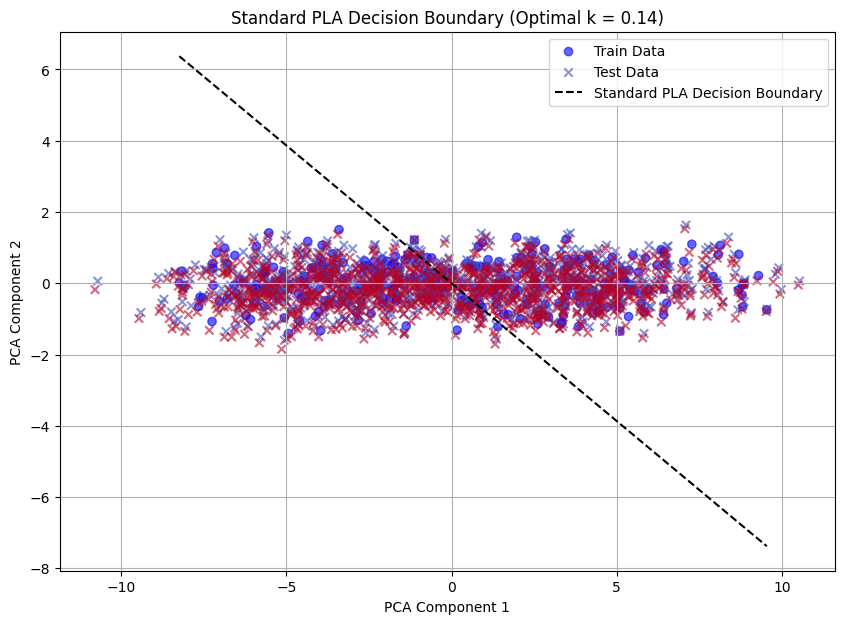

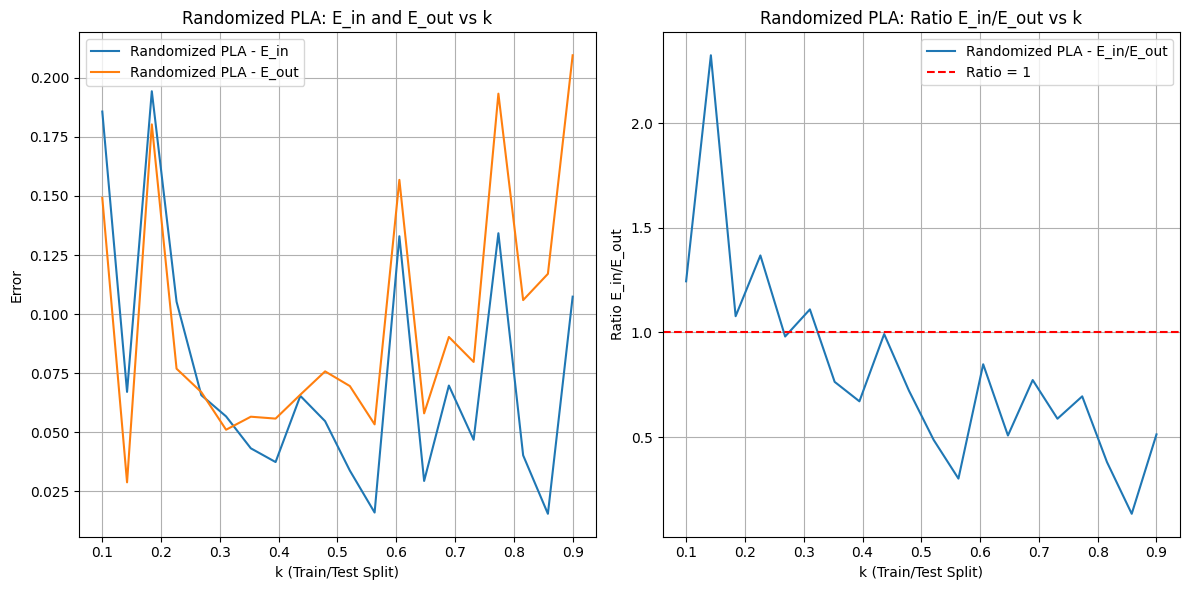

Optimal k for Randomized PLA: 0.4368421052631579


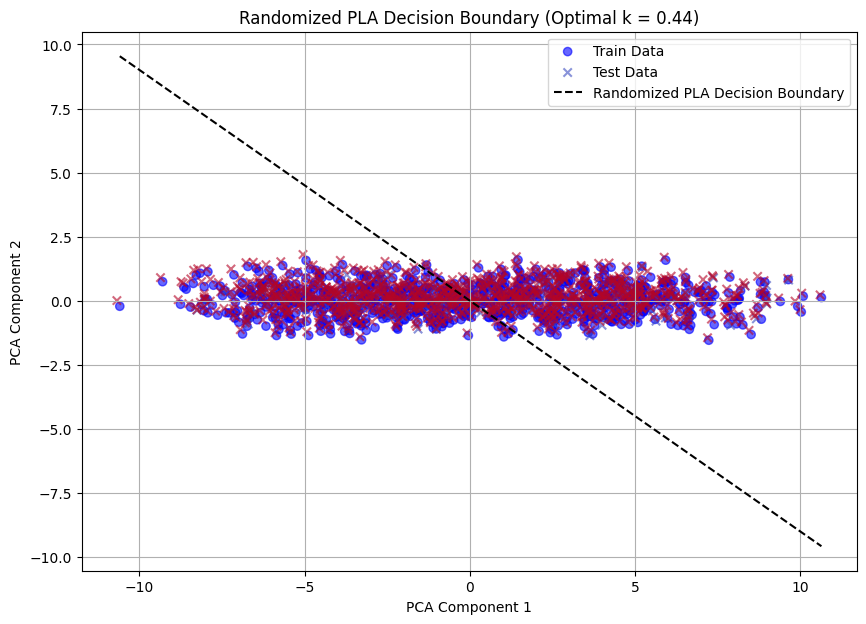

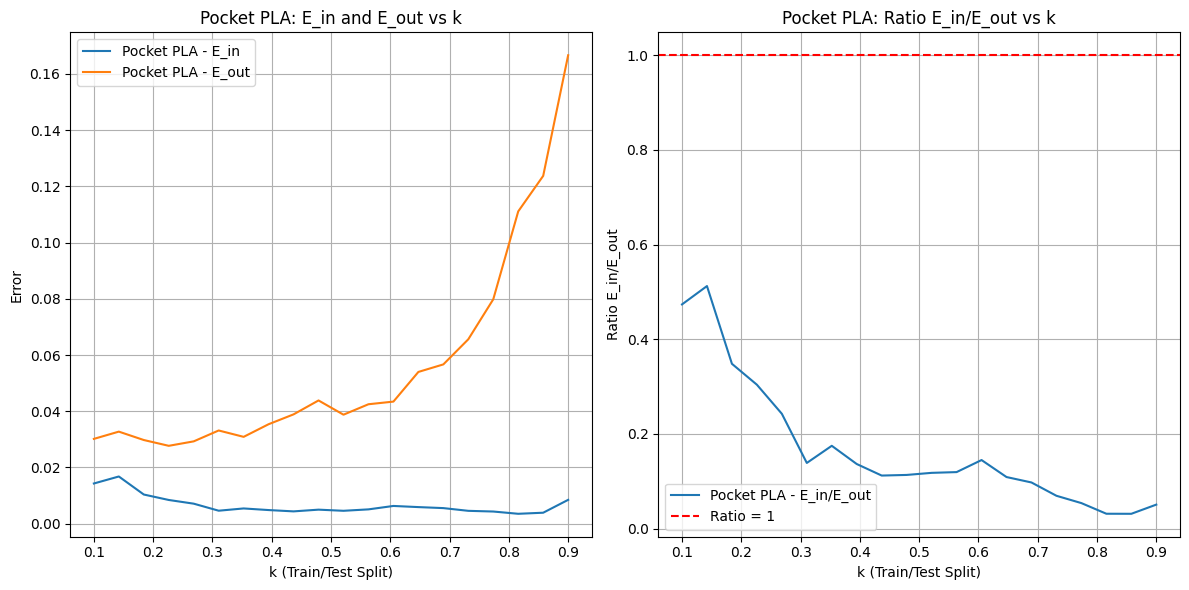

Optimal k for Pocket PLA: 0.14210526315789473


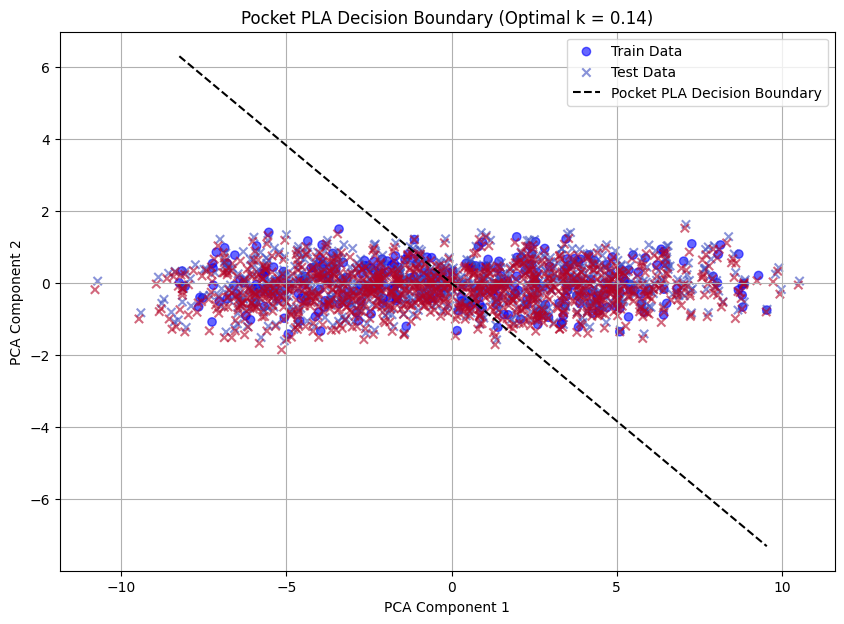

In [ ]:
k_values = np.linspace(0.1, 0.9, 20)

# Find the best k for each method and plot ratio
methods = ['standard', 'randomized', 'pocket']

for method in methods:
    optimal_k, ratio_values, E_in_values, E_out_values = find_best_k_ratio(X, y, method, k_values)

    plt.figure(figsize=(12, 6))

    # Plot E_in and E_out
    plt.subplot(1, 2, 1)
    plt.plot(k_values, E_in_values, label=f'{method.capitalize()} PLA - E_in')
    plt.plot(k_values, E_out_values, label=f'{method.capitalize()} PLA - E_out')
    plt.title(f"{method.capitalize()} PLA: E_in and E_out vs k")
    plt.xlabel("k (Train/Test Split)")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)

    # Plot Ratio E_in/E_out vs k
    plt.subplot(1, 2, 2)
    plt.plot(k_values, ratio_values, label=f'{method.capitalize()} PLA - E_in/E_out')
    plt.axhline(1, color='red', linestyle='--', label='Ratio = 1')
    plt.title(f"{method.capitalize()} PLA: Ratio E_in/E_out vs k")
    plt.xlabel("k (Train/Test Split)")
    plt.ylabel("Ratio E_in/E_out")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Optimal k for {method.capitalize()} PLA: {optimal_k}")
    plot_decision_boundary_for_optimal_k(X, y, method=f"{method}", optimal_k=optimal_k)
